Генерация слоя городских кварталов с помощью blocksnet

In [370]:
!pip install blocksnet  -q
!pip install blocksnet ipykernel mapclassify -qq


In [371]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import os


In [ ]:
data_path = "../data/scenario 3 - data"
results_path = "../results/scenario 3 - results"

<h3>Загрузка границ, дорог, построение полигонов</h3>

<Axes: >

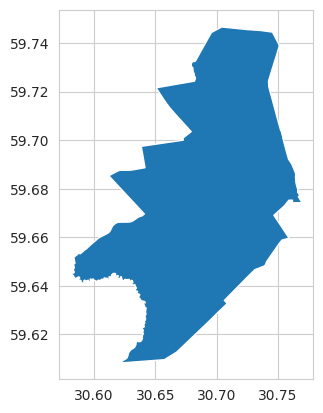

In [373]:
boundary = gpd.read_file(os.path.join(data_path,'boundary.geojson'))
boundary.plot()

<Axes: >

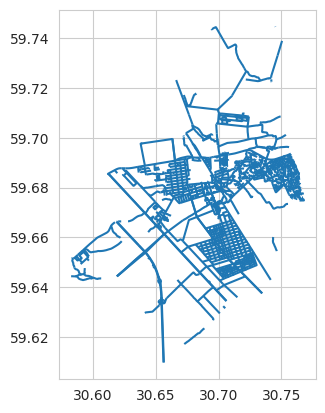

In [374]:
roads = gpd.read_file(os.path.join(data_path,'roads.geojson'))
roads.plot()

In [375]:
local_crs = boundary.estimate_utm_crs()
local_crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [376]:
boundary = boundary.reset_index()[['geometry']].to_crs(local_crs)
roads = roads.reset_index()[['geometry']].to_crs(local_crs)

In [377]:
import momepy

roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])]
GAP_TOLERANCE = 1
def _get_roads(roads):
    merged = roads.unary_union
    if merged.geom_type == 'MultiLineString':
        roads = gpd.GeoDataFrame(geometry=list(merged.geoms), crs=roads.crs)
    else:
        roads = gpd.GeoDataFrame(geometry=[merged], crs=roads.crs)
    roads = roads.explode(index_parts=False).reset_index(drop=True)
    roads.geometry = momepy.close_gaps(roads, GAP_TOLERANCE)
    roads = roads[roads.geom_type.isin(['LineString'])]
    return roads

roads = _get_roads(roads)
roads

geometry
0     LINESTRING (365800.816 6614215.997, 367077.835...
1     LINESTRING (367077.835 6615272.832, 367091.830...
2     LINESTRING (367091.830 6615284.414, 367969.594...
3     LINESTRING (367969.594 6616010.834, 367985.367...
4     LINESTRING (367985.367 6616023.887, 367994.047...
...                                                 ...
2292  LINESTRING (370679.328 6616812.333, 370686.307...
2293  LINESTRING (370534.922 6613716.713, 370594.304...
2294  LINESTRING (370594.304 6613657.816, 371168.862...
2295  LINESTRING (370708.197 6617224.519, 370661.785...
2296  LINESTRING (370661.785 6617319.707, 370657.148...

[2297 rows x 1 columns]

In [378]:
from blocksnet import BlocksGenerator

bg = BlocksGenerator(boundary, roads, None, None)

2024-12-24 18:51:59.366 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:99 - Check boundaries schema
2024-12-24 18:51:59.402 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:103 - Check roads schema
2024-12-24 18:51:59.449 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:109 - Check railways schema
2024-12-24 18:51:59.463 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:115 - Check water schema
2024-12-24 18:51:59.469 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:124 - Exclude water objects


In [379]:
blocks = bg.run()
blocks

2024-12-24 18:51:59.526 | INFO     | blocksnet.preprocessing.blocks_generator:run:161 - Generating blocks
2024-12-24 18:51:59.563 | INFO     | blocksnet.preprocessing.blocks_generator:run:170 - Setting up enclosures
2024-12-24 18:51:59.711 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Filling holes
2024-12-24 18:51:59.798 | INFO     | blocksnet.preprocessing.blocks_generator:run:178 - Dropping overlapping blocks
2024-12-24 18:51:59.926 | INFO     | blocksnet.preprocessing.blocks_generator:run:192 - Calculating blocks area
2024-12-24 18:51:59.943 | INFO     | blocksnet.preprocessing.blocks_generator:run:199 - Blocks generated


geometry
0    POLYGON ((365800.816 6614215.997, 367077.835 6...
1    POLYGON ((367077.835 6615272.832, 365800.816 6...
2    POLYGON ((367077.835 6615272.832, 367091.830 6...
3    POLYGON ((367091.830 6615284.414, 367969.594 6...
4    POLYGON ((367969.594 6616010.834, 367985.367 6...
..                                                 ...
547  POLYGON ((370824.817 6614531.358, 370896.802 6...
548  POLYGON ((370934.251 6614415.621, 370950.838 6...
549  POLYGON ((370950.838 6614355.840, 370970.176 6...
550  POLYGON ((370550.689 6614311.582, 370341.405 6...
551  POLYGON ((370620.950 6614330.640, 370550.689 6...

[552 rows x 1 columns]

<Axes: >

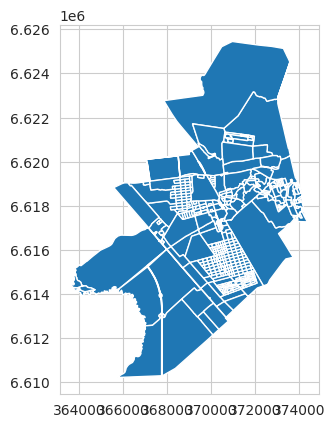

In [380]:
blocks.plot()

In [381]:
blocks.to_file(os.path.join(results_path,'blocks_blocksnet_1.geojson'))

### Свои дороги

In [382]:
CRS = 32636
SPEED_M_MIN = 1000

import networkx as nx

def _roads_to_graph(roads):
    graph = momepy.gdf_to_nx(roads)
    graph.graph['crs'] = roads.crs.to_epsg()
    graph = nx.DiGraph(graph)
    for _, _, data in graph.edges(data=True):
        geometry = data['geometry']
        data['time_min'] = geometry.length / SPEED_M_MIN
        # data['weight'] = data['mm_len'] / 1000 / 1000
        # data['length_meter'] = data['mm_len'] / 1000
    for n, data in graph.nodes(data=True):
        graph.nodes[n]['x'] = n[0]  # Assign X coordinate to node
        graph.nodes[n]['y'] = n[1]

    return graph

roads_G = _roads_to_graph(roads)
roads_G

In [383]:
from blocksnet import AccessibilityProcessor
AccessibilityProcessor._fix_graph(roads_G)

In [384]:
from blocksnet import AccessibilityProcessor

ap = AccessibilityProcessor(blocks)
acc_mx = ap.get_accessibility_matrix(roads_G)
acc_mx.head() # вывод первых 5 строк полученной матрицы

0         1         2         3         4         5         6    \
0  0.000000  5.746094  2.437500  2.492188  6.406250  3.595703  5.972656   
1  5.746094  0.000000  3.312500  3.257812  5.906250  2.152344  4.484375   
2  2.437500  3.312500  0.000000  0.053497  3.966797  1.159180  3.537109   
3  2.492188  3.257812  0.053497  0.000000  3.996094  1.105469  3.482422   
4  6.406250  5.906250  3.966797  3.996094  0.000000  3.792969  6.128906   

        7          8          9    ...       542       543       544  \
0  3.626953  12.226562  11.695312  ...  8.242188  8.429688  7.980469   
1  2.136719   9.859375   9.078125  ...  6.750000  6.945312  6.492188   
2  1.190430   9.789062   9.265625  ...  5.804688  5.996094  5.542969   
3  1.137695   9.734375   9.210938  ...  5.750000  5.945312  5.492188   
4  3.783203  12.382812  11.859375  ...  8.398438  8.585938  8.132812   

        545       546       547       548       549       550       551  
0  7.933594  7.992188  7.980469  8.054688  7.953125  7.906250  7.933594  
1  6.441406  6.503906  6.492188  6.566406  6.464844  6.414062  6.441406  
2  5.496094  5.558594  5.546875  5.621094  5.515625  5.468750  5.496094  
3  5.441406  5.503906  5.492188  5.566406  5.464844  5.414062  5.441406  
4  8.085938  8.148438  8.140625  8.210938  8.109375  8.062500  8.085938  

[5 rows x 552 columns]

In [385]:
from blocksnet.models import City
from blocksnet import Accessibility, Connectivity

blocks['land_use'] = None

city = City(
    blocks=blocks,
    acc_mx=acc_mx
)

connectivity = Connectivity(city_model=city)
connectivity_result = connectivity.calculate()
connectivity_result

geometry  connectivity
id                                                                  
0    POLYGON ((365800.816 6614215.997, 367077.835 6...      7.253906
1    POLYGON ((367077.835 6615272.832, 365800.816 6...      5.460938
2    POLYGON ((367077.835 6615272.832, 367091.830 6...      4.820312
3    POLYGON ((367091.830 6615284.414, 367969.594 6...      4.765625
4    POLYGON ((367969.594 6616010.834, 367985.367 6...      7.390625
..                                                 ...           ...
547  POLYGON ((370824.817 6614531.358, 370896.802 6...      4.257812
548  POLYGON ((370934.251 6614415.621, 370950.838 6...      4.335938
549  POLYGON ((370950.838 6614355.840, 370970.176 6...      4.398438
550  POLYGON ((370550.689 6614311.582, 370341.405 6...      4.515625
551  POLYGON ((370620.950 6614330.640, 370550.689 6...      4.562500

[552 rows x 2 columns]

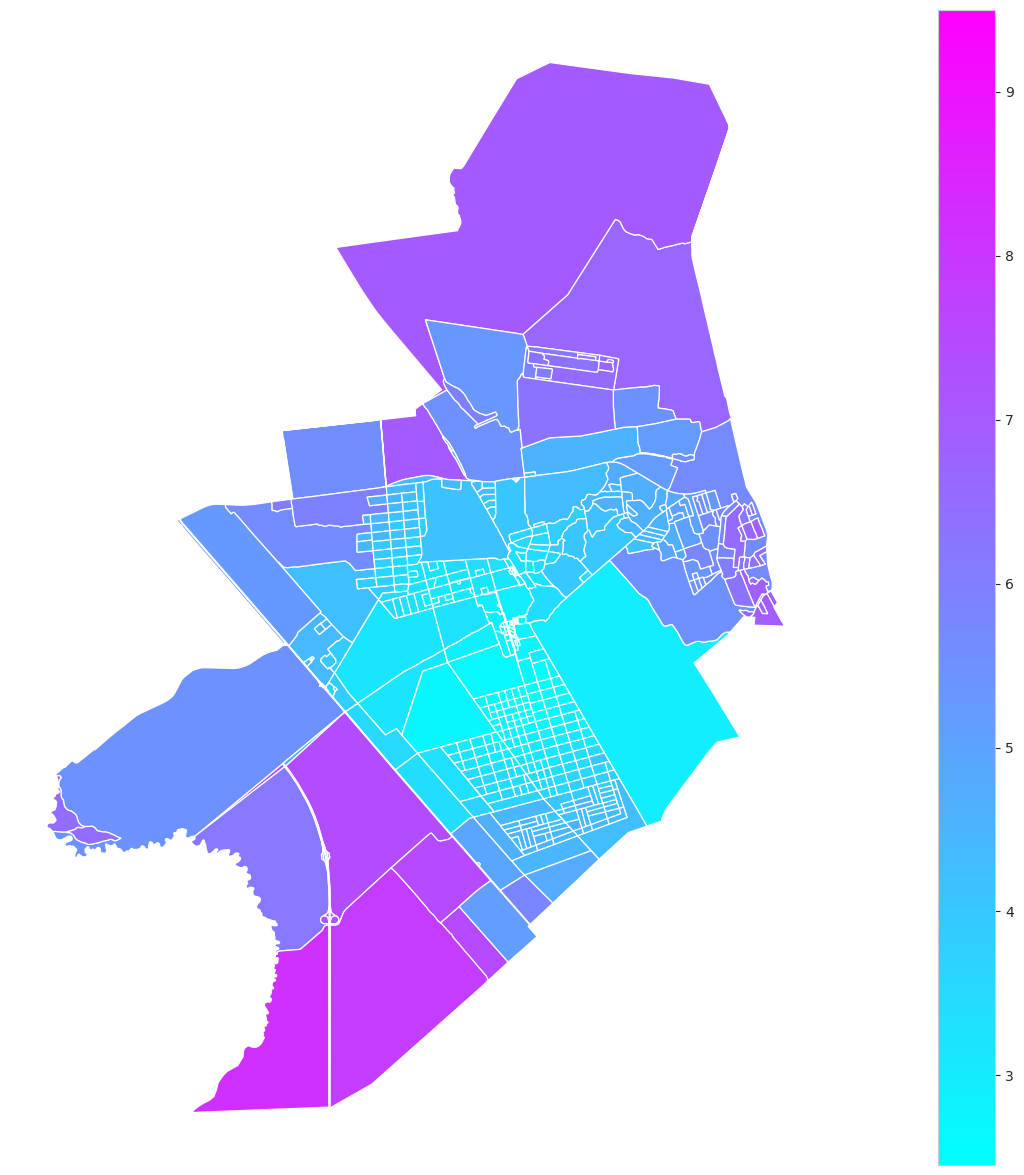

In [386]:
Connectivity.plot(connectivity_result, linewidth=0.9, figsize=(30,15))

In [387]:
import os
acc_mx.to_pickle(os.path.join(results_path,'acc_mx_1.pickle'))
city.to_pickle(os.path.join(results_path,'city_model_scenario 1.pickle'))

----

###Загрузка зданий

In [388]:
buildings = gpd.read_file(os.path.join(data_path,'buildings.geojson'))
buildings.explore()

In [389]:
buildings = buildings.to_crs(local_crs) # переводим здания в локальную систему координат
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [390]:
buildings

population building:levels  is_living      type  id  living_area  \
0            139               1          1      None NaN      12464.0   
1            173               1          1      None NaN      15429.0   
2            197               1          1      None NaN      17636.0   
3             90               1          1      None NaN       8050.0   
4            123               1          1      None NaN      10948.0   
...          ...             ...        ...       ...  ..          ...   
4934           0               1          0  building NaN          NaN   
4935           0               1          1  building NaN        106.0   
4936           0               1          1  building NaN        106.0   
4937           0               1          1  building NaN        103.0   
4938           0               1          1  building NaN         47.0   

         building                                           geometry  
0     residential  MULTIPOLYGON (((370784.561 6614885.336, 370698...  
1     residential  MULTIPOLYGON (((370698.434 6615007.925, 370784...  
2     residential  MULTIPOLYGON (((370698.434 6615007.925, 370618...  
3     residential  MULTIPOLYGON (((370618.534 6615121.652, 370698...  
4     residential  MULTIPOLYGON (((370618.534 6615121.652, 370529...  
...           ...                                                ...  
4934         None  MULTIPOLYGON (((371083.463 6616832.478, 371105...  
4935  residantial  MULTIPOLYGON (((370660.184 6617353.896, 370660...  
4936  residantial  MULTIPOLYGON (((370646.427 6617582.335, 370651...  
4937  residantial  MULTIPOLYGON (((370591.537 6617578.189, 370596...  
4938  residantial  MULTIPOLYGON (((367248.292 6618852.769, 367248...  

[4939 rows x 8 columns]

In [391]:
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]
buildings.head()

population building:levels  is_living  type  id  living_area     building  \
0         139               1          1  None NaN      12464.0  residential   
1         173               1          1  None NaN      15429.0  residential   
2         197               1          1  None NaN      17636.0  residential   
3          90               1          1  None NaN       8050.0  residential   
4         123               1          1  None NaN      10948.0  residential   

                                            geometry  
0  MULTIPOLYGON (((370784.561 6614885.336, 370698...  
1  MULTIPOLYGON (((370698.434 6615007.925, 370784...  
2  MULTIPOLYGON (((370698.434 6615007.925, 370618...  
3  MULTIPOLYGON (((370618.534 6615121.652, 370698...  
4  MULTIPOLYGON (((370618.534 6615121.652, 370529...

In [392]:
# Сброс индекса, чтобы превратить индексы в обычные столбцы
buildings = buildings.reset_index(drop=True)
# Проверяем результат
buildings.head()

population building:levels  is_living  type  id  living_area     building  \
0         139               1          1  None NaN      12464.0  residential   
1         173               1          1  None NaN      15429.0  residential   
2         197               1          1  None NaN      17636.0  residential   
3          90               1          1  None NaN       8050.0  residential   
4         123               1          1  None NaN      10948.0  residential   

                                            geometry  
0  MULTIPOLYGON (((370784.561 6614885.336, 370698...  
1  MULTIPOLYGON (((370698.434 6615007.925, 370784...  
2  MULTIPOLYGON (((370698.434 6615007.925, 370618...  
3  MULTIPOLYGON (((370618.534 6615121.652, 370698...  
4  MULTIPOLYGON (((370618.534 6615121.652, 370529...

In [393]:
# Преобразуем столбец 'building:levels' в числовой тип, ошибки будут заменены на NaN
buildings['building:levels'] = pd.to_numeric(buildings['building:levels'], errors='coerce')

# Заполним пропущенные значения (NaN) нулями или другими подходящими значениями
buildings = buildings.fillna(0)

# Добавляем или преобразуем необходимые атрибуты

# 1. Количество этажей (number_of_floors)
buildings['number_of_floors'] = buildings.apply(
    lambda x: x['building:levels'] if x['building:levels'] > 1 else 1,
    axis=1
)

# 2. Площадь застройки (footprint_area) - как площадь геометрии (основание здания)
buildings['footprint_area'] = buildings.geometry.area

# 3. Общая площадь всех этажей (build_floor_area) - footprint_area * number_of_floors
buildings['build_floor_area'] = buildings['footprint_area'] * buildings['number_of_floors']

# 4. Жилая площадь (living_area) и нежилая площадь (non_living_area)
# Жилая площадь будет рассчитываться только для жилых зданий
residential_tags = ['residential', 'house', 'apartments', 'detached', 'terrace', 'dormitory', 'yes']
buildings['living_area'] = buildings.apply(
    lambda x: 0.8 * x['build_floor_area'] if x['building'] in residential_tags else 0,
    axis=1
)

# Нежилая площадь будет 20% от общей площади этажей
buildings['non_living_area'] = buildings['build_floor_area'] - buildings['living_area']

# 5. Население (population) - для жилых зданий
buildings['population'] = buildings.apply(
    lambda x: 48 * x['number_of_floors'] if x['building'] in residential_tags else 0,
    axis=1
)

# Теперь удалим все остальные столбцы, кроме 'geometry', 'build_floor_area', 'living_area', 'non_living_area',
# 'footprint_area', 'number_of_floors', 'population'
buildings = buildings[['geometry', 'build_floor_area', 'living_area', 'non_living_area',
                       'footprint_area', 'number_of_floors', 'population']]

# Проверим результат
buildings


geometry  build_floor_area  \
0     MULTIPOLYGON (((370784.561 6614885.336, 370698...      12458.692388   
1     MULTIPOLYGON (((370698.434 6615007.925, 370784...      15423.437949   
2     MULTIPOLYGON (((370698.434 6615007.925, 370618...      17628.785193   
3     MULTIPOLYGON (((370618.534 6615121.652, 370698...       8046.384657   
4     MULTIPOLYGON (((370618.534 6615121.652, 370529...      10944.039281   
...                                                 ...               ...   
4934  MULTIPOLYGON (((371083.463 6616832.478, 371105...        525.565495   
4935  MULTIPOLYGON (((370660.184 6617353.896, 370660...        105.650230   
4936  MULTIPOLYGON (((370646.427 6617582.335, 370651...        106.014300   
4937  MULTIPOLYGON (((370591.537 6617578.189, 370596...        103.229590   
4938  MULTIPOLYGON (((367248.292 6618852.769, 367248...         47.247866   

       living_area  non_living_area  footprint_area  number_of_floors  \
0      9966.953910      2491.738478    12458.692388                 1   
1     12338.750359      3084.687590    15423.437949                 1   
2     14103.028154      3525.757039    17628.785193                 1   
3      6437.107726      1609.276931     8046.384657                 1   
4      8755.231425      2188.807856    10944.039281                 1   
...            ...              ...             ...               ...   
4934      0.000000       525.565495      525.565495                 1   
4935      0.000000       105.650230      105.650230                 1   
4936      0.000000       106.014300      106.014300                 1   
4937      0.000000       103.229590      103.229590                 1   
4938      0.000000        47.247866       47.247866                 1   

      population  
0             48  
1             48  
2             48  
3             48  
4             48  
...          ...  
4934           0  
4935           0  
4936           0  
4937           0  
4938           0  

[4939 rows x 7 columns]

In [394]:
city.update_buildings(buildings)

2024-12-24 18:52:16.310 | INFO     | blocksnet.models.city:update_buildings:1237 - Removing existing blocks from the model
2024-12-24 18:52:16.334 | INFO     | blocksnet.models.city:update_buildings:1241 - Joining buildings and blocks
Update blocks buildings: 100%|██████████| 403/403 [00:01<00:00, 249.98it/s]


Empty GeoDataFrame
Columns: [geometry, build_floor_area, living_area, non_living_area, footprint_area, number_of_floors, population]
Index: []

In [395]:
city.to_pickle(os.path.join('city_model.pickle'))

In [396]:
city.get_buildings_gdf().explore()

---------

###Загрузка сервисов

In [412]:
import os
import geopandas as gpd
from shapely.geometry import Point
from blocksnet import ServiceType

directory = os.fsencode(f"{data_path}/servises/")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".geojson"):
        service_name = filename.removesuffix(".geojson")
        print(f"Adding service {service_name}")
        service_gdf = gpd.read_file(f"{data_path}/servises/" + filename)
        service_gdf.to_crs(local_crs, inplace=True)
        service = service_gdf[["geometry"]]
        try:
          city.update_services(service_name, service)
        except:
          continue
    else:
        continue

Adding service school
Adding service bus_station
Adding service supermarket
Adding service kindergarten


In [413]:
services_gdf = city.get_services_gdf()
services_gdf

geometry  block_id  service_type  capacity    area  \
0    POINT (368442.931 6619283.069)        10   bus_station        70   150.0   
1    POINT (368789.692 6619375.635)        14   bus_station        70   150.0   
2    POINT (369708.369 6616372.323)        16   bus_station        70   150.0   
3    POINT (370108.164 6615802.889)        16   bus_station        70   150.0   
4    POINT (369717.709 6616424.543)        17   bus_station        70   150.0   
..                              ...       ...           ...       ...     ...   
117  POINT (371441.472 6614737.056)       537        school       250  2200.0   
118  POINT (371288.632 6615811.968)       540   supermarket       200   100.0   
119  POINT (371288.632 6615811.968)       540  kindergarten        80   180.0   
120  POINT (371328.815 6615679.891)       541        school       250  2200.0   
121  POINT (370894.207 6614321.548)       549   supermarket       200   100.0   

     is_integrated  building_id  
0            False          NaN  
1            False          NaN  
2            False          NaN  
3            False          NaN  
4            False          NaN  
..             ...          ...  
117           True        161.0  
118           True        125.0  
119           True        125.0  
120           True        126.0  
121           True        170.0  

[122 rows x 7 columns]

---------------

In [414]:
services_gdf_super = services_gdf[services_gdf["service_type"]=="supermarket"]
services_gdf_super

geometry  block_id service_type  capacity   area  \
32   POINT (370536.194 6617850.865)       172  supermarket       300  200.0   
33   POINT (370359.774 6617309.620)       173  supermarket       300  200.0   
44   POINT (370517.951 6615172.602)       374  supermarket       200  100.0   
45   POINT (370544.785 6615322.491)       375  supermarket       200  100.0   
47   POINT (370262.783 6615678.021)       381  supermarket       200  100.0   
48   POINT (370178.744 6615661.681)       382  supermarket       200  100.0   
50   POINT (370565.115 6616335.021)       387  supermarket       200  100.0   
52   POINT (370750.229 6616233.615)       389  supermarket       200  100.0   
53   POINT (370634.054 6616106.795)       391  supermarket       200  100.0   
54   POINT (370787.492 6616110.395)       392  supermarket       200  100.0   
57   POINT (370908.262 6615711.036)       399  supermarket       200  100.0   
59   POINT (370799.272 6615393.962)       402  supermarket       200  100.0   
62   POINT (371029.360 6615310.595)       405  supermarket       200  100.0   
64   POINT (371150.051 6614911.499)       411  supermarket       200  100.0   
65   POINT (369523.862 6615479.507)       415  supermarket       200  100.0   
66   POINT (369915.431 6615587.644)       417  supermarket       200  100.0   
69   POINT (371017.918 6616026.434)       427  supermarket       200  100.0   
70   POINT (371293.449 6615957.911)       428  supermarket       200  100.0   
71   POINT (371293.449 6615957.911)       428  supermarket       200  100.0   
73   POINT (370375.038 6616275.921)       433  supermarket       200  100.0   
75   POINT (370889.524 6616638.612)       436  supermarket       200  100.0   
78   POINT (371066.532 6616469.858)       437  supermarket       200  100.0   
79   POINT (371179.901 6616214.086)       441  supermarket       200  100.0   
81   POINT (371555.131 6615598.248)       444  supermarket       200  100.0   
85   POINT (371723.286 6615065.463)       450  supermarket       200  100.0   
87   POINT (371569.139 6614873.674)       454  supermarket       200  100.0   
88   POINT (371341.281 6614962.873)       456  supermarket       200  100.0   
94   POINT (371725.853 6615213.069)       478  supermarket       200  100.0   
95   POINT (371300.596 6615096.689)       482  supermarket       200  100.0   
96   POINT (370873.594 6614981.361)       484  supermarket       200  100.0   
99   POINT (370117.919 6614920.647)       490  supermarket       200  100.0   
101  POINT (370123.227 6614780.395)       491  supermarket       200  100.0   
103  POINT (369766.300 6615403.740)       498  supermarket       200  100.0   
105  POINT (369995.855 6615322.728)       499  supermarket       200  100.0   
107  POINT (370614.926 6615490.737)       505  supermarket       200  100.0   
109  POINT (370266.532 6615102.875)       509  supermarket       200  100.0   
111  POINT (370794.870 6615246.651)       515  supermarket       200  100.0   
112  POINT (371178.750 6615497.447)       517  supermarket       200  100.0   
113  POINT (371409.955 6615413.199)       518  supermarket       200  100.0   
114  POINT (370155.844 6615978.702)       520  supermarket       200  100.0   
115  POINT (370126.280 6616077.412)       527  supermarket       200  100.0   
118  POINT (371288.632 6615811.968)       540  supermarket       200  100.0   
121  POINT (370894.207 6614321.548)       549  supermarket       200  100.0   

     is_integrated  building_id  
32           False          NaN  
33           False       4668.0  
44            True          5.0  
45            True          6.0  
47            True         11.0  
48            True         12.0  
50            True         16.0  
52            True         57.0  
53            True         18.0  
54            True         58.0  
57            True         62.0  
59            True         65.0  
62            True         67.0  
64            True         70.0  
65            True         71.0  
66    

In [415]:
services_gdf.explore()

###Подсчёт обеспеченности

Bus stantion

2024-12-24 18:55:50.840 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 60 : 368x46
2024-12-24 18:55:51.928 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:55:52.659 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:55:53.186 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


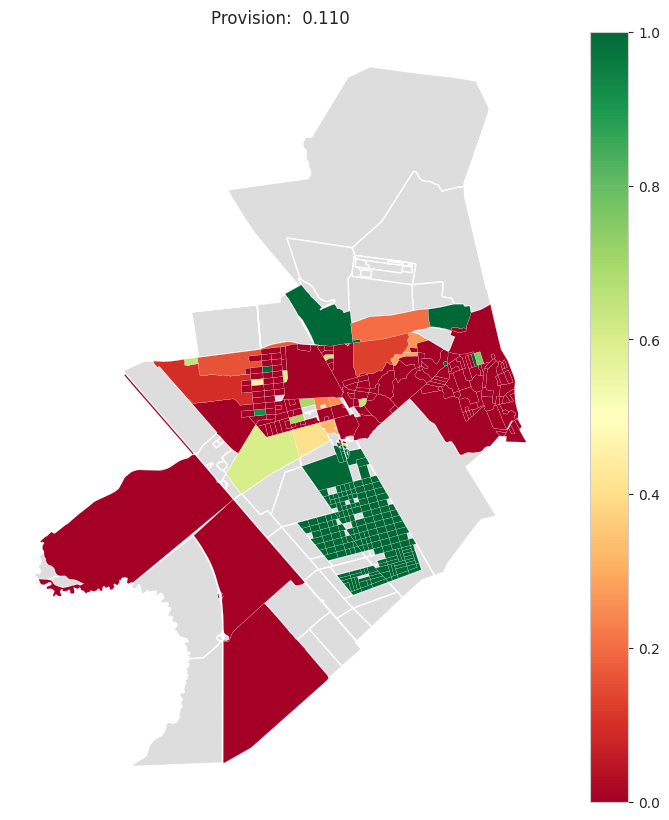

In [416]:
from blocksnet import Provision, ProvisionMethod
service_type = 'bus_station'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:55:54.048 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 7 : 368x17
2024-12-24 18:55:54.430 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:55:54.718 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:55:55.025 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


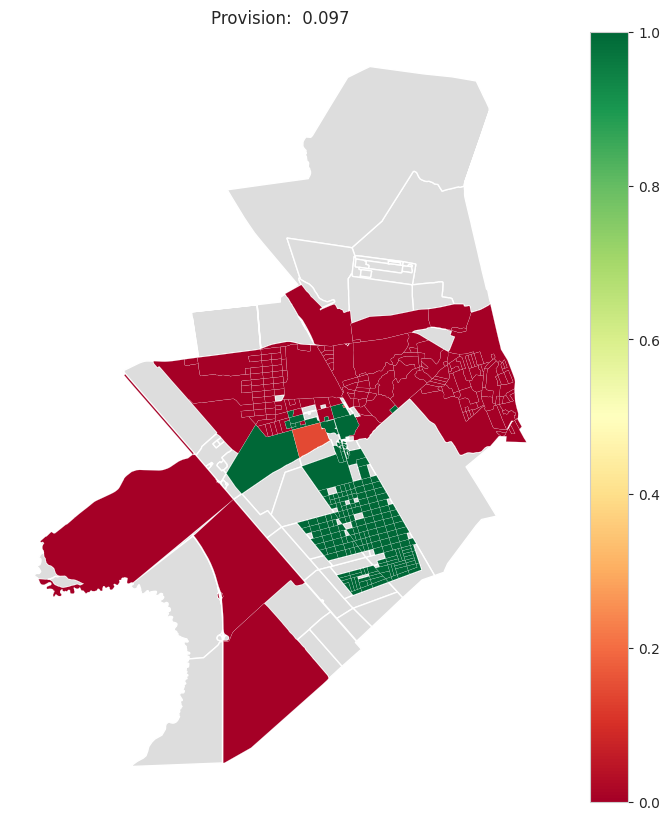

In [417]:
from blocksnet import Provision, ProvisionMethod
service_type = 'kindergarten'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:55:55.857 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 368x8
2024-12-24 18:55:56.056 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:55:56.179 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:55:56.411 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


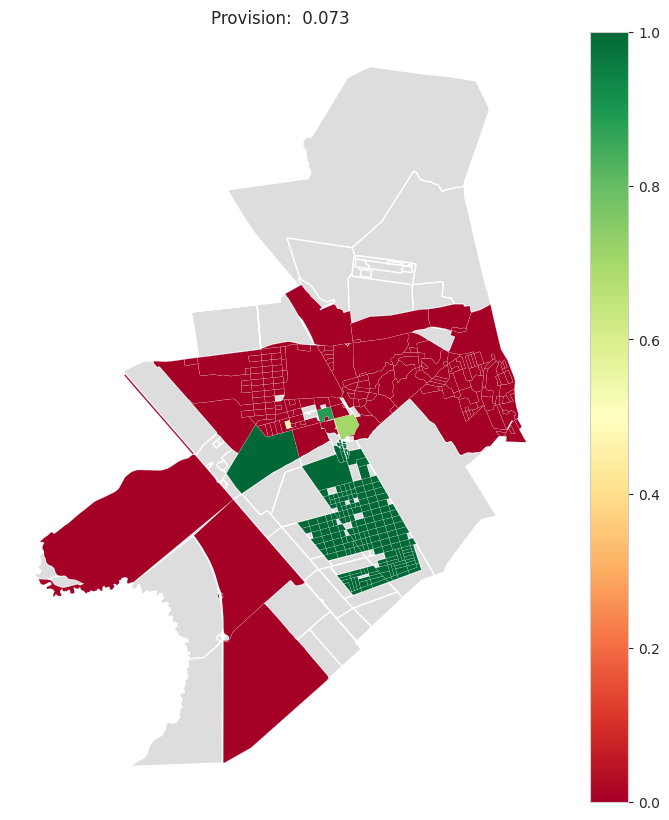

In [418]:
from blocksnet import Provision, ProvisionMethod
service_type = 'school'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

2024-12-24 18:55:57.268 | INFO     | blocksnet.method.provision:_lp_provision:320 - Setting an LP problem for accessibility = 15 : 368x42
2024-12-24 18:55:58.259 | INFO     | blocksnet.method.provision:_lp_provision:354 - Solving the problem
2024-12-24 18:55:58.886 | INFO     | blocksnet.method.provision:_lp_provision:358 - Restoring values from variables
2024-12-24 18:55:59.432 | SUCCESS  | blocksnet.method.provision:calculate:269 - Provision assessment finished


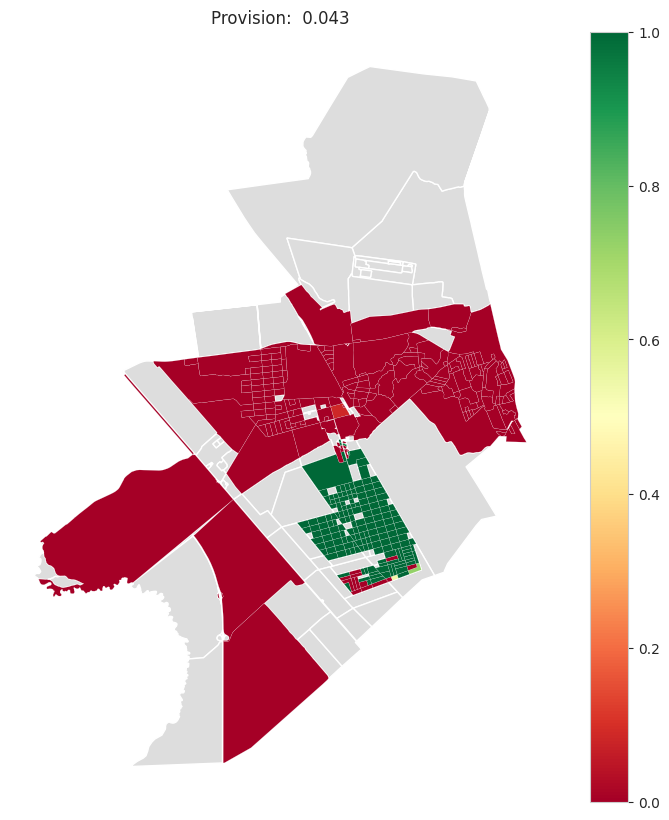

In [419]:
from blocksnet import Provision, ProvisionMethod
service_type = 'supermarket'
prov = Provision(city_model=city)
prov_res = prov.calculate(service_type)
prov.plot(prov_res)

-------

###Оценка центральности по транспортной связности и разнообразию сервисов в кварталах

In [404]:
from blocksnet import Centrality, PopulationCentrality

In [423]:
centrality = Centrality(city_model=city)
result_centrality = centrality.calculate()
result_centrality

geometry  connectivity  \
id                                                                     
0    POLYGON ((365800.816 6614215.997, 367077.835 6...      7.253906   
1    POLYGON ((367077.835 6615272.832, 365800.816 6...      5.460938   
2    POLYGON ((367077.835 6615272.832, 367091.830 6...      4.820312   
3    POLYGON ((367091.830 6615284.414, 367969.594 6...      4.765625   
4    POLYGON ((367969.594 6616010.834, 367985.367 6...      7.390625   
..                                                 ...           ...   
547  POLYGON ((370824.817 6614531.358, 370896.802 6...      4.257812   
548  POLYGON ((370934.251 6614415.621, 370950.838 6...      4.335938   
549  POLYGON ((370950.838 6614355.840, 370970.176 6...      4.398438   
550  POLYGON ((370550.689 6614311.582, 370341.405 6...      4.515625   
551  POLYGON ((370620.950 6614330.640, 370550.689 6...      4.562500   

      density  diversity  centrality  
id                                    
0         NaN        NaN         NaN  
1         NaN        NaN         NaN  
2         NaN        NaN         NaN  
3         NaN        NaN         NaN  
4         NaN        NaN         NaN  
..        ...        ...         ...  
547       NaN        NaN         NaN  
548       NaN        NaN         NaN  
549  0.000055       -0.0    0.139632  
550       NaN        NaN         NaN  
551       NaN        NaN         NaN  

[552 rows x 5 columns]

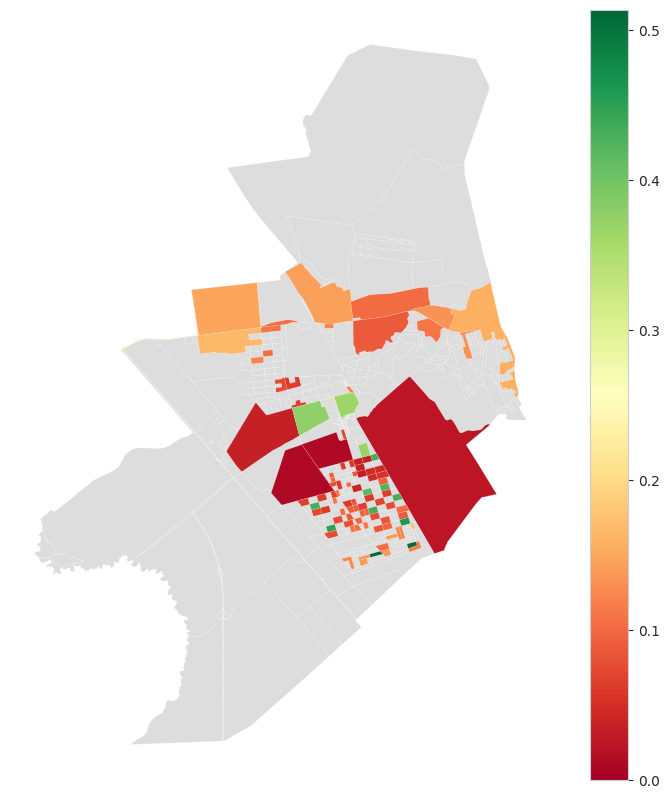

In [424]:
Centrality.plot(result_centrality, figsize =(10,10))

###Оценка центральности по транспортной связности и населению в квартала

In [426]:
centrality_population = PopulationCentrality(city_model=city)
result_centrlity_population = centrality_population.calculate()
result_centrlity_population

geometry  population_centrality
id                                                                           
0    POLYGON ((365800.816 6614215.997, 367077.835 6...                   0.09
1    POLYGON ((367077.835 6615272.832, 365800.816 6...                   0.03
2    POLYGON ((367077.835 6615272.832, 367091.830 6...                   0.09
3    POLYGON ((367091.830 6615284.414, 367969.594 6...                   0.85
4    POLYGON ((367969.594 6616010.834, 367985.367 6...                   0.27
..                                                 ...                    ...
547  POLYGON ((370824.817 6614531.358, 370896.802 6...                   4.48
548  POLYGON ((370934.251 6614415.621, 370950.838 6...                   3.68
549  POLYGON ((370950.838 6614355.840, 370970.176 6...                   3.58
550  POLYGON ((370550.689 6614311.582, 370341.405 6...                   3.15
551  POLYGON ((370620.950 6614330.640, 370550.689 6...                   3.87

[558 rows x 2 columns]

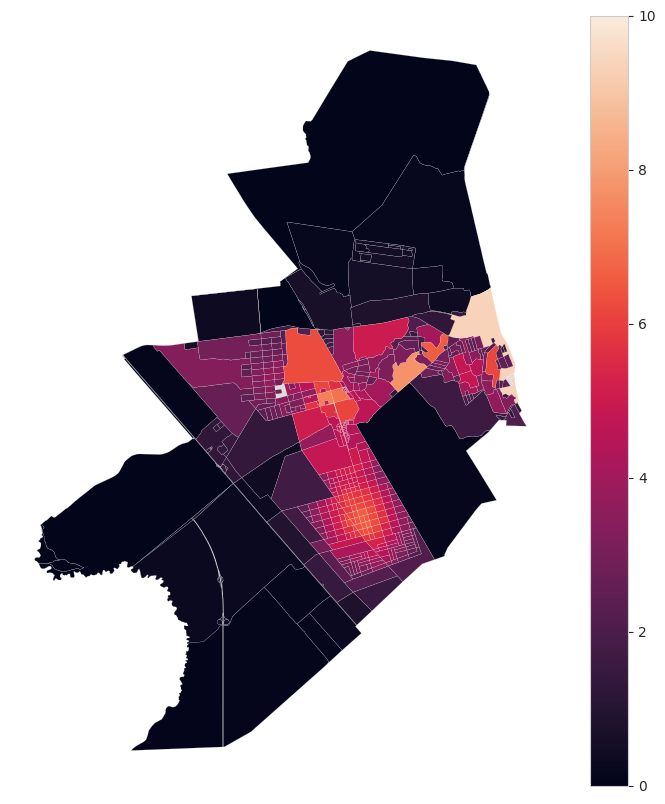

In [427]:
PopulationCentrality.plot(result_centrlity_population, figsize =(10,10))

-----------------------

### Доступность

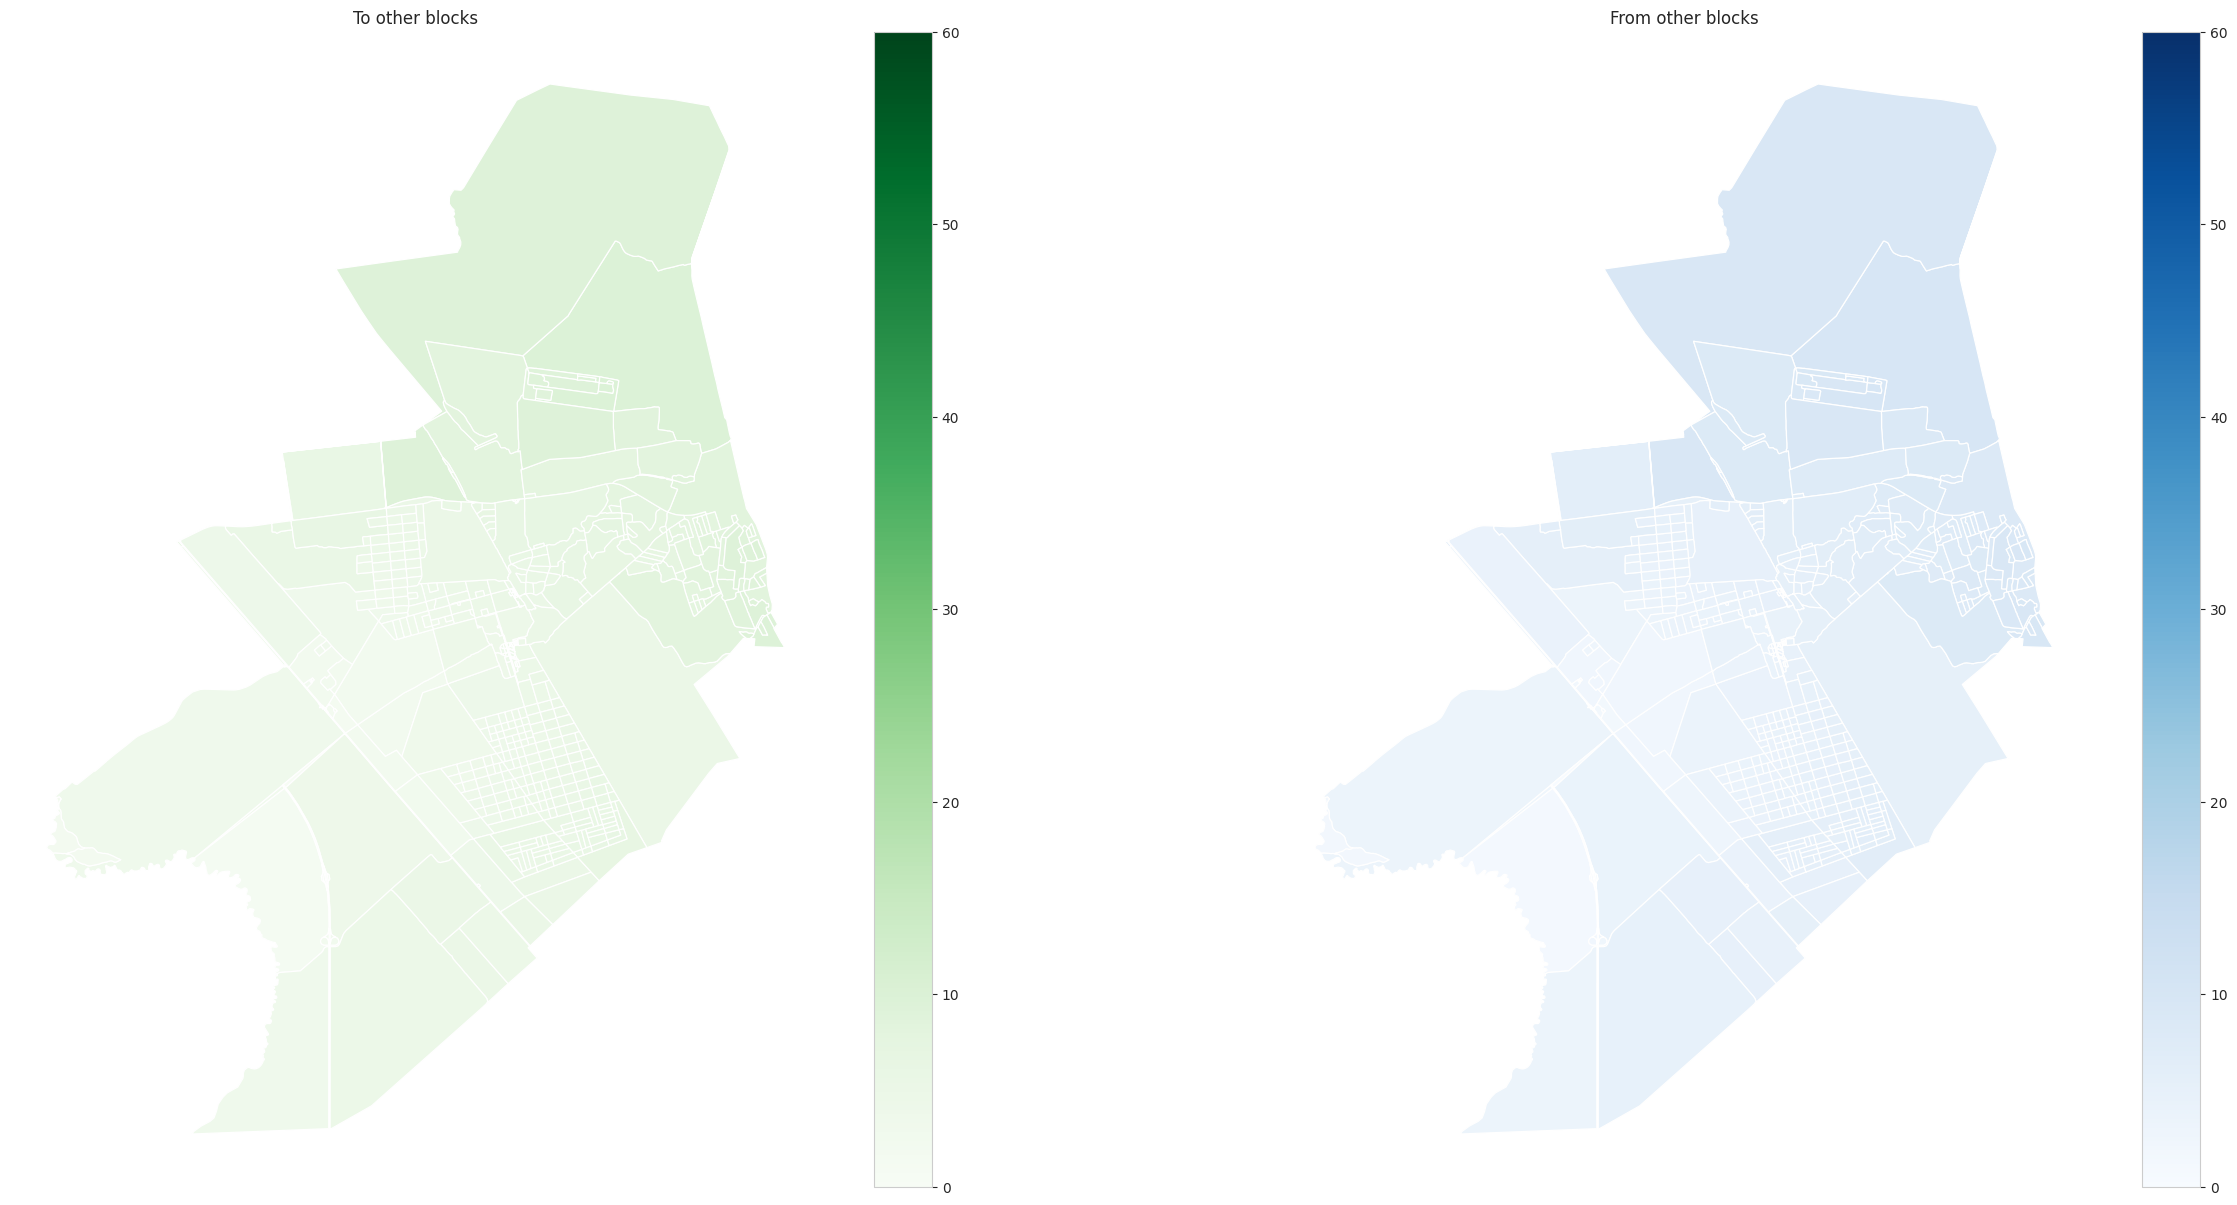

In [409]:
from blocksnet import Accessibility, Connectivity
accessibility = Accessibility(city_model=city)
block = city[2] # квартал от которого будем считать доступность
result = accessibility.calculate(block)

Accessibility.plot(result, linewidth=0.9, figsize=(30,15))

In [410]:
city.to_pickle(os.path.join(results_path,'city_model_scenario 1.pickle'))